# ロジスティック回帰

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 課題

タイタニックの乗客データを利用しロジスティック回帰モデルを作成
特徴量抽出をしてみる

年齢が30歳で男の乗客は生き残れるか？

In [28]:
# titanic data csvファイルの読み込み
titanic_df = pd.read_csv('./data/titanic_train.csv')
# ファイルの先頭部を表示し、データセットを確認する
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
#nullを含んでいる行を表示
titanic_df[titanic_df.isnull().any(1)].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S


In [30]:
#Ageカラムのnullを中央値で補完

titanic_df['AgeFill'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())

#再度nullを含んでいる行を表示 (Ageのnullは補完されている)
titanic_df[titanic_df.isnull().any(1)]

#titanic_df.dtypes

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.000000
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.000000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.000000
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,29.699118
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,25.000000
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,39.000000
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,27.000000
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,29.699118


## ロジスティック回帰モデル

識別モデルとして$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$を用いる。

ただし、$\sigma(\cdot)$はシグモイド関数であり、$\sigma(h) = \frac{1}{1 + \exp{(-h)}}$で定義される。

また、陽には書かないが、$\boldsymbol{x}$には定数項のための$1$という要素があることを仮定する。

## 学習

訓練データ <br>
$\displaystyle X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ..., \boldsymbol{x}_{n}]^{\mathrm{T}}, \boldsymbol{y} = [y_{1}, y_{2}, ..., y_{n}]^{\mathrm{T}} (y_{i} = \{0, 1\})$ 
<br>
に対して尤度関数$L$は以下のように書ける。
<br>

$\displaystyle L(\boldsymbol{w}) = \prod_{i=1}^{n} p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})^{y_{i}} (1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))^{1 - y_{i}}$


負の対数尤度関数は <br>
$\displaystyle - \log{L(\boldsymbol{w})} = - \sum_{i=1}^{n} \left[ y_{i} \log{p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})} + (1 - y_{i}) \log{(1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))} \right]$ <br>
のように書ける。 これを最小化する$\boldsymbol{w}$を求める。<br>
<br>

$\displaystyle \frac{d \sigma(h)}{d h} = \sigma(h)(1 - \sigma(h))$と書けることを考慮し、負の対数尤度関数を$\boldsymbol{w}$で偏微分すると、
<br>

$\displaystyle \begin{aligned}
\frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})}) &=& -\sum_{i=1}^{n} \left[ y_{i} (1 - \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i})) - (1 - y_{i}) \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) \right] \boldsymbol{x}_{i}  \cr
&=& \sum_{i=1}^{n} \left( \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) - y_{i} ) \right)\boldsymbol{x}_{i}
\end{aligned}$

<br>

この式が$0$となる$\boldsymbol{w}$は解析的に求められないので、今回は$-\log{L(\boldsymbol{w})}$の最小化問題を最急降下法を用いて解く。
<br>

最急降下法では学習率を$\eta$とすると、以下の式で$\boldsymbol{w}$を更新する。
<br>

$\displaystyle \boldsymbol{w} \leftarrow \boldsymbol{w} - \eta \frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})})$

In [36]:
def add_one(x):
    return np.concatenate([np.ones(len(x))[:,None], x], axis=1)

In [76]:
#運賃だけのリストを作成
x_train = titanic_df.loc[:,["AgeFill","Fare"]]
#生死フラグのみのリストを作成
y_train = titanic_df.loc[:,"Survived"]

(891,)
(891, 2)
(891,)


In [77]:
def sigmoid(x):
    sig_r = 34.538776394910684
    condlist = [x < -sig_r, (x >= -sig_r) & (x < sig_r), x >= sig_r]
    funclist = [1e-15, lambda a: 1.0 / (1.0 + np.exp(-a)), 1.0 - 1e-15]
    return np.piecewise(x, condlist, funclist)

def sgd(X_train, max_iter, eta):
    w = np.zeros(X_train.shape[1])
    for _ in range(max_iter):
        w_prev = np.copy(w)
        sigma = sigmoid(np.dot(X_train, w))
        grad = np.dot(X_train.T, (sigma - y_train))
        w -= eta * grad
        if np.allclose(w, w_prev):
            return w
    return w
X_train = add_one(x_train)
max_iter=891
eta = 0.01
w = sgd(X_train, max_iter, eta)
print(w)

[-93.35823144 -59.36017887  87.17512656]


## 予測

入力に対して、$y=1$である確率を出力する。よって

$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$の値が

$0.5$より大きければ1に、小さければ0に分類する。

In [78]:
xx0, xx1 = np.meshgrid(np.linspace(-5, 5, 891), np.linspace(-5, 5, 891))
xx = np.array([xx0, xx1]).reshape(2, -1).T

In [79]:
X_test = add_one(xx)
proba = sigmoid(np.dot(X_test, w))
y_pred = (proba > 0.5).astype(np.int)

In [83]:
print(x_train.values)

[[22.          7.25      ]
 [38.         71.2833    ]
 [26.          7.925     ]
 ...
 [29.69911765 23.45      ]
 [26.         30.        ]
 [32.          7.75      ]]


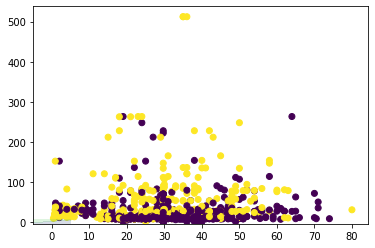

In [84]:
plt.scatter(x_train.values[:, 0], x_train.values[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba.reshape(891, 891), alpha=0.2, levels=np.linspace(0, 1, 3))

/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


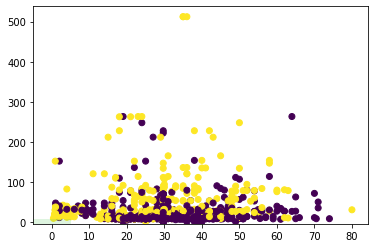

In [87]:
#sklern実装

from sklearn.linear_model import LogisticRegression
model=LogisticRegression(fit_intercept=True)
model.fit(x_train, y_train)
proba = model.predict_proba(xx)
y_pred = (proba > 0.5).astype(np.int)
plt.scatter(x_train.values[:, 0], x_train.values[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba[:, 0].reshape(891, 891), alpha=0.2, levels=np.linspace(0, 1, 3))

In [ ]:
#運賃だけのリストを作成
data1 = titanic_df.loc[:, ["Fare"]].values

In [ ]:
#生死フラグのみのリストを作成
label1 =  titanic_df.loc[:,["Survived"]].values

In [ ]:
model=LogisticRegression()

In [ ]:
model.fit(data1, label1)

In [ ]:
model.predict([[61]])